# Observing Etna Eruption
<small><i>This use case was prepared with support from European Space Agency.</i></small>


## 1 Introduction 
In early spring 2017, Sicilian biggest volcano - Etna - awakened and erupted several times. The Etna eruption has started on January 23rd 2017 but intensified after February 27th and the activity continued in following months.
<br>
<figure>
    <img src='https://3c1703fe8d.site.internapcdn.net/newman/gfx/news/hires/2017/2-10injuredine.jpg' width='600' height='600' />
    <figcaption style="text-align:center">Etna eruption on 16.3.2017 (<a href="https://phys.org/news/2017-03-explosion-erupting-mount-etna-volcano.html">source</a>).</figcaption>
</figure>
<br>

In this exercise we will demonstrate how such events can be observed using satellite images. We will utilize imagery acquired from satellites Sentinel 2 and Landsat 8.

Before we start we need to set up two "technical" things:

1) The text and code you see here are written in Jupyter Notebook. You will need to "execute cells" to see satellite images. You can do that by clicking on the cell and then pressing "ctrl + Enter". 

2) We will use sentinel-hub to download the data. A provisional access is already provided for your convenience (i.e. a long number assigned to INSTANCE_ID variable) but it will support only limited number of requests to avoid abuse. If you want to play around and request more data, you will need to create your own one account and replace the value of INSTANCE_ID with your own one. Check instructions to do so <a href="https://sentinelhub-py.readthedocs.io/en/latest/examples/ogc_request.html#Sentinel-Hub-account">here</a>.

In [2]:
# This is a first cell that needs to be executed. To do so click on it and press: "ctrl + Enter"
# limited education instance 
INSTANCE_ID = 'cf8091e5-2837-463e-b45d-8dc0b121cad7'

<i>A text "In [\*]" before a cell indicates that the cell is being executed. When the "\*" turns into number, e.g. "In [3]" it means that the cell was successfully executed and you can see the results of execution below the cell. Some cells do not return any results but just set up things that will be used latter</i>

Back to Etna now. First we will import all python modules that we need and define two functions, which we will use to visualize images nicely and interactively:

In [3]:
# Set options
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import external modules
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, DataSource, CustomUrlParam, geo_utils
import datetime
import numpy as np
import matplotlib.pyplot as plt
import requests as  r
import ipywidgets as widgets
from IPython.display import display
from matplotlib_scalebar.scalebar import ScaleBar

In [4]:
#Two functions, which will help us plot images nicely and visualize time series
def plot_image(image, bbox, factor=1):
    """
    Utility function for plotting RGB images.
    
    :param image: image to be plotted
    :type image: numpy array
    :param bbox: bounding box object, which will be used to set the extent of the plot
    :type bbox: sentinelhub.common.bbox
    :param factor: factor
    :type factor: int
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
    
    bbox_polygon = bbox.get_polygon()

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1), extent=[bbox_polygon[0][0], bbox_polygon[2][0], bbox_polygon[0][1], bbox_polygon[2][1]])
    else:
        plt.imshow(image, extent=[bbox_polygon[0][0], bbox_polygon[2][0], bbox_polygon[0][1], bbox_polygon[2][1]])
    
    #Add axes' lables
    if bbox.get_crs() == CRS.WGS84 :
        plt.xlabel('longitude [°]')
        plt.ylabel('latitude [°]')
    else:
        plt.xlabel('easting  [m]')
        plt.ylabel('northing [m]')
        
    #Add scalebar
    width = image.shape[1]
    height = image.shape[2]
    resx, resy = geo_utils.bbox_to_resolution(bbox, width, height) 
    scalebar = ScaleBar((width*resx)/(bbox_polygon[2][0]-bbox_polygon[0][0]), 'm', location='lower right', box_alpha=0.9)
    plt.gca().add_artist(scalebar)
    
  
def visualize_images(images, dates, i, R, G, B):
    """
    This function will draw an image selected from the list of "images" for a given "date". 
    It is linked to dropdown list from which user can select image to be drawn.
    
    :param images: satellite images, each array corresponds to a single image and has shape [height, width, channels]. 
    :type images: list of numpy arrays
    :param dates: dates of acquisition of satellite images 
    :type dates: list of datetime
    :param i: value of current selection in the widget
    :type i: datetime
    :param R: indexs, which represent the image of a channel, which will be drawn with red color
    :type R: int
    :param G: indexs, which represent the image of a channel, which will be drawn with green color
    :type G: int
    :param B: indexs, which represent the image of a channel, which will be drawn with blue color
    :type B: int
    """

    plot_image(images[dates.index(i)][:, :, [R, G, B]],etna_bbox, 2.5)


Now we will request a satellite data from sentinel-hub. Let's go for a "true color" image first.

In [5]:
# Define the bounding box of the area of interest (AOI), coordinates can be read from e.g., EO Browser
etna_bbox_web_mercator = [14.96, 37.70, 15.06, 37.78]
etna_bbox = BBox(bbox=etna_bbox_web_mercator, crs=CRS.WGS84)

# Prepare a request, we follow the example here: https://sentinelhub-py.readthedocs.io/en/latest/examples/ogc_request.html#Example-1:-True-color-(PNG)-on-a-specific-date
true_color_request_s2 = WmsRequest(data_folder='data',
                           layer='TRUE-COLOR-S2-L1C',
                           bbox=etna_bbox,
                           time=('2017-02-27','2017-04-18'),
                           width=512,
                           maxcc=0.8,
                           instance_id=INSTANCE_ID,
                           custom_url_params={CustomUrlParam.SHOWLOGO: False})

# Download the data and printout the number of images
true_color_img_s2 = true_color_request_s2.get_data(save_data=True)
true_color_dates_s2 = true_color_request_s2.get_dates()
print('We downloaded %d images, each one acquired on different date (i.e. time series). ' % len(true_color_img_s2))
print('Single image is of type {} and has shape {}. First two dimensions are size of downloaded image in pixels and the last is a number of downloaded bands).'.format(type(true_color_img_s2[-1]), true_color_img_s2[-1].shape))

We downloaded 11 images, each one acquired on different date (i.e. time series). 
Single image is of type <class 'numpy.ndarray'> and has shape (516, 512, 3). First two dimensions are size of downloaded image in pixels and the last is a number of downloaded bands).


Everything looks good. To display one of the downloaded images, run the cell below:

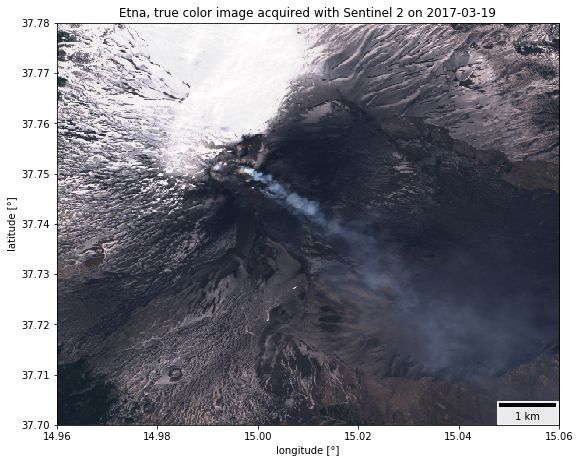

In [7]:
# Display one of the true color images.
display_image = 4 # USER: Change this number to any value between 0 and 10 (number of images-1) to dispaly any other downloaded image.
plot_image(true_color_img_s2[display_image], etna_bbox)
plt.title('Etna, true color image acquired with Sentinel 2 on '+ str(true_color_dates_s2[display_image].date()));
print()

We can see Etna! This vizualisation is called a <b>true color composite</b> because the scene appears as it would be seen by a human observer (i.e. snow and clouds appear white, soil appears dark, etc.). To be honest, it is difficult interprete this concrete image. We notice different white surfaces, which might be either snow, smoke or clouds. If we look more carefully we can notice a shadow on the right lower corner indicating that there is a mountain in the image. Knowing that it is Etna, we can recognize a crater and smoke fuming out of the crater. Lava is dark and it is thus impossible to distinguish it from soil or see it through the smoke.

But we know lava is much hotter than soil. Could we make use of the lava's "hotness" to see it?

## 2 Some Background

### 2.1 Wien's Displacement  Law
Every object which is hotter than absolute zero (0° Kelvin) emits electromagnetic radiation - the hotter the object, the higher the frequency at which the most of radiation is emitted (i.e. the shorter the wavelength $\lambda$). This relationship is described by Wien's displacement law:

\begin{equation*}
\lambda_{max}=\frac{b}{T}
\end{equation*}

where:
 - $\lambda_{max}$ is λ, at which the body with temperature $T$ emits the most of electromagnetic energy
 - $b = 2.9*10^{-3}$ is Wien's displacement constant
 - $T$ is temperature of the object

By ploting radiation curves for objects with different temperatures we can present the "displacemets" of their maximum:
<figure>
    <img src='https://upload.wikimedia.org/wikipedia/commons/d/df/Blackbody_emission.svg' width='600' height='600' />
    <figcaption style="text-align:center">Blackbody Radiation Curves by user Ant Beck from Wikimedia Commons</figcaption>
</figure>
<br>
The Sun's temperature is between 5000K and  6000K and its radiation has a peak around 0.5 micrometer, which corresponds to  visible part of the spectrum. Whereas Earth's radiation peaks around 10 micrometer, it doesn emit visible light thus we cannot see it with naked eye unless it is illumitated by the Sun (or some other source of visible light).

### 2.2 Satellite's Bands
Another concept that we need to familiarize ourselves with is the concept of satellite bands. Sensors carried by satellites like Sentinel 2 or Landsat 8 can image our Earth in different parts of the electromagnetic spectrum. 
The light that we see as humans can generally be thought of as having three components or bands: red, blue and green. Remember the true color image from earlier? That is a representation of the images aqcuired in red, blue and green bands of the satellite. These bands roughy match our own human vision and the image therefore appears in the same way as it would be seen by a human observer in space. 
But satellites can see much more of the electromagnetic spectrum than we humans can. For example, Sentinel 2 is also observing the near infrared and shortwave infrared parts of the electromagnetic spectrum. These correspond to much longer wavelengths than the visible light. Below is a table of Sentinel 2's bands and their wavelength.

| Sentinel-2 Band             | Central Wavelength (nm) |
|-----------------------------|-------------------------|
| Band 1: Coastal Aerosol     | 442.7                   |
| Band 2: Blue                | 492.4                   |
| Band 3: Green               | 559.8                   |
| Band 4: Red                 | 664.6                   |
| Band 5: Vegetation Red Edge | 704.1                   |
| Band 6: Vegetation Red Edge | 740.5                   |
| Band 7: Vegetation Red Edge | 782.8                   |
| Band 8: Near Infrared (NIR) | 832.8                   |
| Band 8a: Narrow NIR         | 864.7                   |
| Band 9: Water Vapour        | 945.1                   |
| Band 10: Shortwave Infrared | 1373.5                  |
| Band 11: Shortwave Infrared | 1613.7                  |
| Band 12: Shortwave Infrared | 2202.4                  |


Most of the objects on Earth surface can be imaged by Sentinel 2 and Landsat 8 only because they reflect Sun's radiation, which has a peak in visible part of electromagnetic spectrum. Would we still be able to see anything in the satellite images if  we turned the Sun off (or if the satellites captured images by night)? 

Well, very little but yes, we would still see "hot-enough" objects on Earth surface, which emit radiation with "short-enough" wavelengths, which can be captured by the "last" satellite's band, i.e. the band sensitive to the longest wavelengths. In case of Sentinel 2 this is band 12 and "short-enouhg" for Sentinel 2 would mean wavelengths around 2202 nm. Fortunately for us, lava erupted from Etna in 2017 was "hot-enough".

## 3 Visualizing Etna's Eruption

### 3.1 Sentinel 2 Images
To utilize these concepts, we will create a visualization based on data acquired in infra red part of electromagnetic spectrum (https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial). We will use:
- Band 04 (B04), which measures radiation of electromagnetic waves with wavelengths around 665 nm
- Band 11 (B11), which measures radiation of electromagnetic waves with wavelengths around 1610 nm 
- Band 12 (B12), which measures radiation of electromagnetic waves with wavelengths around 2190 nm

To visualize these data, will use red color for image acquired with B12, green color for image acquired with B11 and blue color for image acquired with B04. Let check how that looks like:

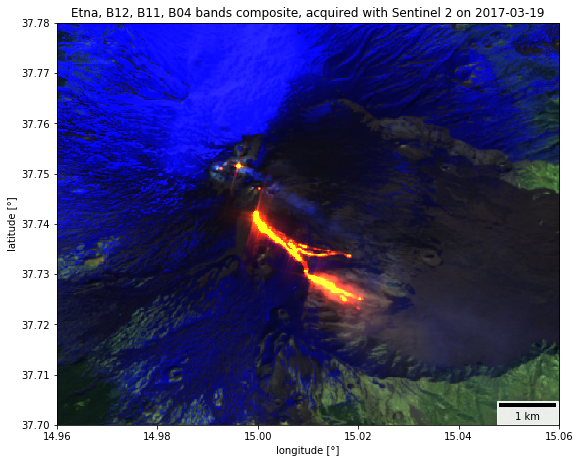

In [8]:
bands_request_s2 = WmsRequest(data_folder='data',
                               layer='BANDS-S2-L1C',
                               bbox=etna_bbox,
                               time=('2017-02-27','2017-04-18'),
                               width=512,
                               image_format=MimeType.TIFF_d32f,
                               maxcc=0.8,
                               instance_id=INSTANCE_ID,
                               custom_url_params={CustomUrlParam.SHOWLOGO: False})

bands_img_s2 = bands_request_s2.get_data(save_data=True)
bands_dates_s2 = bands_request_s2.get_dates()

plot_image(bands_img_s2[display_image][:, :, [12, 11, 3]], etna_bbox, 2.5) #Numbers 12, 11, 3 do not indicate bands but indexed of bands_img_s2 array. 
plt.title('Etna, B12, B11, B04 bands composite, acquired with Sentinel 2 on '+ str(bands_dates_s2[display_image].date()))
print()

This is a composite of bands B12, B11 and B04. The image is much different from true color image, here we can easily distinguish snow from smoke. More interestingly hot lava flow can now be nicely observed. It appears red and yellow due to high values in B12 (red color) and in B11 (green color). However, in nature lava would (still) be black (dark) as we saw in true color image.

Now that we know hot to visualize data in a useful way, let's put all images acquired during Etna's eruption together to gain some understanding of the dynamic of the phenomenon:

In [11]:
print()
dropdown_date_s2 = widgets.Dropdown(
                                options=bands_dates_s2,
                                value=bands_dates_s2[4],
                                description='Date:',
                                disabled=False,
                                )

widgets.interact(visualize_images, images=widgets.fixed(bands_img_s2), dates=widgets.fixed(bands_dates_s2), i=dropdown_date_s2, R=widgets.fixed(12), G=widgets.fixed(11), B=widgets.fixed(3));

A Jupyter Widget

Quite nice, right? We can see the lava first flowed towards south-esat and then it turned to south-west. Image from 27.2.2017 is very cloudy almost useless but still interesting since it tells us that some activity in Etna's crater had started in February already. 


### 3.2 Landsat 8 Images
So far we have used images acquired from Sentinel 2 satellite. We could check if there are any available (and cloudless) images from other satellites, which could revealed additional information about the event. Landsat 8, which has similar sensors as Sentinel 2 on board, seems the most promising choice. Let's request the data:

We downloaded 6 images, each one acquired on different date (i.e. time series). 
Single image is of type <class 'numpy.ndarray'> and has shape (516, 512, 3). First two dimensions are size of downloaded image in pixels and the last is a number of downloaded bands: red, green blue).



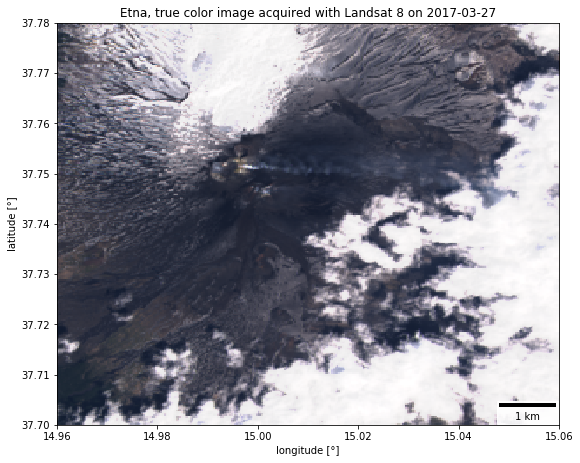

In [12]:
true_color_request_l8 = WmsRequest(data_folder='data',
                                       data_source=DataSource.LANDSAT8,
                                        layer='TRUE-COLOR-L8',
                                        bbox=etna_bbox,
                                        time=('2017-02-25','2017-04-18'),
                                        width=512,
                                        maxcc=0.8,
                                        instance_id=INSTANCE_ID,
                                        custom_url_params={CustomUrlParam.SHOWLOGO: False})

true_color_img_l8 = true_color_request_l8.get_data(save_data=True)
true_color_dates_l8 = true_color_request_l8.get_dates()
print('We downloaded %d images, each one acquired on different date (i.e. time series). ' % len(true_color_img_l8))
print('Single image is of type {} and has shape {}. First two dimensions are size of downloaded image in pixels and the last is a number of downloaded bands: red, green blue).'.format(type(true_color_img_l8[-1]), true_color_img_l8[-1].shape))

# Display one of the true color images.
display_image = -3 
plot_image(true_color_img_l8[display_image],etna_bbox)
plt.title('Etna, true color image acquired with Landsat 8 on '+ str(true_color_dates_l8[display_image].date()));
print()

In [13]:
bands_request_l8 = WmsRequest(data_folder='data',
                              data_source=DataSource.LANDSAT8,
                              layer='BANDS-L8',
                              bbox=etna_bbox,
                              time=('2017-02-25','2017-04-18'),
                              width=512,
                              maxcc=0.7,
                              image_format=MimeType.TIFF_d32f,
                              instance_id=INSTANCE_ID,
                              custom_url_params={CustomUrlParam.SHOWLOGO: False})

bands_img_l8 = bands_request_l8.get_data(save_data=True, redownload=True)
bands_dates_l8 = bands_request_l8.get_dates()

print()
dropdown_date_l8 = widgets.Dropdown(
                                options=bands_dates_l8,
                                value=bands_dates_l8[0],
                                description='Date:',
                                disabled=False,
                                )

widgets.interact(visualize_images, images=widgets.fixed(bands_img_l8), dates=widgets.fixed(bands_dates_l8), i=dropdown_date_l8, R=widgets.fixed(6), G=widgets.fixed(5), B=widgets.fixed(7));

A Jupyter Widget

Observing Landsat images we see that lava flow changed its direction more than once. It flowed south-west on 2.3., than it south-east on 18.3. and than south-west again on 27.3.. The image on 12.4. is cloudy and we can not conclude anything about direction of lava flow. 
The image aqcuired on 2.3. does not cover the whole area of interest, since it lies on the edge of the area that satellite captured on that date. 

### 3.3 Combination of Sentinel and Landsat images

We gathered some information from Sentinel 2 images and some from Landsat 8. Let's visualize all together now:

In [14]:
#Show images from Sentinel 2(s2) and landsat 8(l8) sorted by date of acquisition
#Extract only bands that we need
RGB_s2 = [image_on_date[:, :, [12, 11, 3]] for image_on_date in bands_img_s2]
RGB_l8 = [image_on_date[:, :, [6, 5, 7]] for image_on_date in bands_img_l8]

#Create list of tuples (image, date) and sort the list by dates
both_satellites = []
for index, image in enumerate([RGB_s2 + RGB_l8][0]):
    both_satellites.append((image,[bands_dates_s2 + bands_dates_l8][0][index]))
both_satellites_sorted = sorted(both_satellites, key=lambda tup: tup[1])

#Re-arange into seperate lists, which are needed for vizualisation
images_both = [image_date_pair[0] for image_date_pair in both_satellites_sorted]
dates_both = [image_date_pair[1] for image_date_pair in both_satellites_sorted]

In [16]:
# Visualization of time series
print()
dropdown_date_both = widgets.Dropdown(
                                options=dates_both,
                                value=dates_both[0],
                                description='Date:',
                                disabled=False,
                                )

widgets.interact(visualize_images, images=widgets.fixed(images_both), dates=widgets.fixed(dates_both), i=dropdown_date_both, R=widgets.fixed(0), G=widgets.fixed(1), B=widgets.fixed(2));

A Jupyter Widget

Combining images from two different satellites gave us a time series, where we have an image every three or four days. The biggest gapis between 19.3. and 26.3.. As already noticed by analyzing Landsat images lava changed the direction several times. We still can not get much information from cloudy images acquired on 27.2. and on 12.4. but because of combining images from both satellites we do have cloudless images closer to those dates.  
When combining and interpreting images like this, we shall keep in mind the differentces between sensors on both satellites:
- they have different middle wavelengths of cahannels we used used for visualization thus colors can not be accuratly compared,
- they have different spatial resolution thus the surfaces can not be accuratly compared.

## 4 Previous Etna Eruptions

Etna's eruptions in 2017 was of course not the only one. We searched through news about recent eruptions and checked if we can spot them in any of the satellite images. This is what we've found:

1) Etna, image from Landsat 5 on 24.11.2006:
<table>
<tr>
<td>
<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.7381&lng=14.9596&zoom=12&time=2006-11-24&preset=CUSTOM&datasource=Landsat%205%20ESA&layers=B07,B05,B03&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNSoyLjUsQjAzKjIuNV07" target="_blank">
 <img src="images/2006-11-24, Landsat 5 ESA, Custom script.jpg" alt="Drawing" style="width: 1000px;"/>
</a>
</td>
</tr>
<tr>
<td style="text-align:left"> Etna, image from Landsat 5 on 24.11.2006 (<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.7381&lng=14.9596&zoom=12&time=2006-11-24&preset=CUSTOM&datasource=Landsat%205%20ESA&layers=B07,B05,B03&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNSoyLjUsQjAzKjIuNV07">EO Browser link</a>). </td>
</tr>
</table>

First of all we notice yellowish-red lava and a strange rather unnatural pattern in shape of diagonal lines. The lines are a consequence of an anomaly of the sensor. It is a known anomaly, so called "oversaturation" https://landsat.usgs.gov/oversaturation, which happens because the intensity of signal is much stronger than what the sensor can capture (the same effect can be observed on a photography of a very bright object, e.g. sun taken with camera or phone). 
We see dark smoke fuming in south east direction. Its dark shadow indicates that is must contained a lot of ash and that smoke pillar must have been rather high. These observations can be checked by comparison to photos of the event taken in the field https://www.youtube.com/watch?v=zNfrbnRaY0g. 

2) Etna, image from Landsat 8 on 3.12.2015:
<table>
<tr>
<td>
<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.74031&lng=14.98638&zoom=13&time=2015-12-03&preset=CUSTOM&datasource=Landsat%208%20USGS&layers=B07,B06,B04&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNioyLjUsQjA0KjIuNV07" target="_blank">
 <img src="images/2015-12-03, Landsat 8 USGS, Custom script.jpg" alt="Drawing" style="width: 1000px;"/>
</a>
</td>
</tr>
<tr>
<td style="text-align:left"> Etna, image from Landsat 8 on 3.12.2015 (<a href="https://apps.sentinel-hub.com/eo-browser/?lat=37.74031&lng=14.98638&zoom=13&time=2015-12-03&preset=CUSTOM&datasource=Landsat%208%20USGS&layers=B07,B06,B04&evalscript=cmV0dXJuIFtCMDcqMi41LEIwNioyLjUsQjA0KjIuNV07">EO Browser link</a>). </td>
</tr>
</table>

## 5 Conclusions

In this exercise we observed the eruption of the biggest European volcano, Etna. We used and visually analyzed images acquired from Sentinel 2 and Landsat 8 satellites. True color image was difficult to interpret thus we combined images acquired in other parts of electromagnetic spectrum into composite image, which enabled us to distinguish lava from soil and snow from smoke and clouds. Combining images from two different satellites gave us more information about the dynamic of the process but interpretation needs to take into account differences between the sensors.

We also checked satellite images of two previous eruptions reported in news. Image acquired with Landsat 5 was influenced by sensor anomaly called "oversaturation". Sensor anomalies must be taken into account when interpreting satellite images, all known anomalies appearing in Landsat images are collected and described here: https://landsat.usgs.gov/known-issues. 

Did you found this exercise interesting? Why do not you try to find a satellite image of another volcano's eruption. Browse through images with Eo Browser and if you find an interesting image, share a link to it or send it to us and we might include it here.


## 6 References and Other Resources to Check

- Volcanoes by ESA: https://www.esa.int/Our_Activities/Observing_the_Earth/Volcanoes
- Earth's Most Active Volcanoes on Satellite Watch by ESA: https://www.esa.int/Our_Activities/Observing_the_Earth/Earth_s_most_active_volcanoes_on_satellite_watch
- Volcanic Cloud Monitoring: https://volcano.ssec.wisc.edu/
- Sensing Remote Volcanoes by NASA: https://earthdata.nasa.gov/user-resources/sensing-our-planet/sensing-remote-volcanoes
- Known anomalies of Landsat sensors: https://landsat.usgs.gov/known-issues